# k-means

### K均值聚类
实现方法：
- 每个聚类的中心都是属于该类的所有数据点的算术平均值
- 聚类中的每个点相对于其他聚类中心，更靠近本类的中心

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")

In [2]:
"""聚类数据生成器：
数据量n_samples=100，
数据维度n_features=2，
类别数centers=3，
cluster_std表示每个类别的方差
"""
from sklearn import datasets
x, y = datasets.make_blobs(300, centers=4, cluster_std=1, random_state=10)

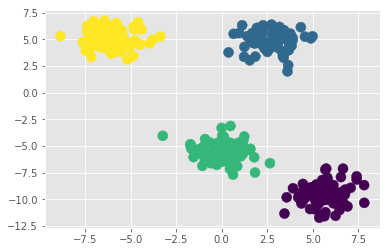

In [3]:
plt.scatter(x[:,0], x[:,1], c=y, s=100)

### opencv中的K均值——cv2.kmeans

In [4]:
import cv2
# 指定参数：迭代10次，误差小于1.0
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
flags = cv2.KMEANS_RANDOM_CENTERS

In [5]:
import numpy as np
compactness, labels, centers = cv2.kmeans(x.astype(np.float32),
                                         4,
                                         None,
                                         criteria,
                                         10,
                                         flags)
# compactness表示每个点到它对应聚类中心的距离的平方和（紧凑值，下文中肘部法则的判定的依据）

In [6]:
compactness

526.6774351084605

In [7]:
centers

array([[-6.0233455 ,  5.07292   ],
       [ 5.6169243 , -9.568959  ],
       [ 2.686961  ,  4.924293  ],
       [ 0.03787707, -5.5010357 ]], dtype=float32)

In [9]:
labels.shape

(300, 1)

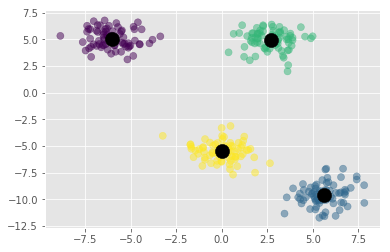

In [12]:
plt.scatter(x[:,0], x[:,1], c=labels[:,0], s=50, alpha=0.5)
plt.scatter(centers[:,0],centers[:,1], c='black', s=200)

# K均值采用的经典方法——期望最大化
- 从一些随机的聚类中心开始
- 一直重复知道收敛
    - 期望步骤： 把所有的数据点分配到离他们最近的聚类中心
    - 最大化步骤： 通过取聚类中心所有点的平均值来更新聚类中心

## 实现期望最大化解决方案
- find_clusters(x, n_clusters, [rseed=])

In [13]:
from sklearn.metrics import pairwise_distances_argmin

In [24]:
def find_clusters(x, n_clusters, rseed=5):
    """
    x: 数据输入
    n_clusters: 聚类的个数
    rseed: 随机种子
    """
    # 初始化
    rng = np.random.RandomState(rseed)
    i = rng.permutation(x.shape[0])[:n_clusters]
    centers = x[i]
    
    # 循环
    while True:
        labels = pairwise_distances_argmin(x, centers)
        # 选择新的聚类中心
        new_centers = np.array([x[labels == i].mean(0)
                                for i in range(n_clusters)])
        # 检查收敛结果，结束while循环
        if np.all(centers == new_centers):
            break
        centers = new_centers
        # 退出函数，返回结果
    return centers, labels

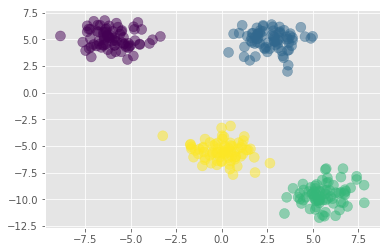

In [25]:
centers, labels = find_clusters(x, 4)
plt.scatter(x[:,0], x[:,1], c=labels, s=100, alpha=0.5)

# 了解期望最大化的局限
1. 不能保证找到全局最优解
2. 需要提前选择聚类个数
3. 聚类边界是线性的
4. K均值在处理大数据集时比较慢

## 1. 不能保证找到全局最优解
- 如下： 聚类中心的随机初始化不成功
- 解决方法： 让算法在多个初始状态下运行
    - opencv默认
    - 也可以通过可选参数attemps来设置

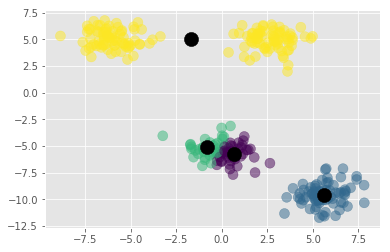

In [40]:
centers, labels = find_clusters(x, 4, rseed=10)
plt.scatter(x[:,0], x[:,1], c=labels, s=100, alpha=0.5)
plt.scatter(centers[:,0],centers[:,1], c='black', s=200)

## 2. 需要提前选择聚类个数
- 如下： 设置几个聚类数就会得到几个聚类
- **解决方法： 肘部法则**

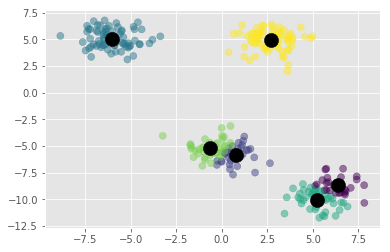

In [43]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
flags = cv2.KMEANS_RANDOM_CENTERS
compactness, labels, centers = cv2.kmeans(x.astype(np.float32),
                                         6,  # 设置为期望得到6个聚类
                                         None,
                                         criteria,
                                         10,
                                         flags)
plt.scatter(x[:,0], x[:,1], c=labels[:,0], s=50, alpha=0.5)
plt.scatter(centers[:,0], centers[:,1], c='black', s=200)

### 肘部法则： 让我们在一个k值范围内重复聚类过程，并记录紧凑值
- 如果结果更复杂，可以考虑更复杂的方法
    - 轮廓分析
    - 高斯混合模型： 使用贝叶斯信息准则来获取聚类的正确数量
    - 具有噪声的基于密度的聚类方法 和 邻近传播法

Text(0.5, 0, 'compactness')

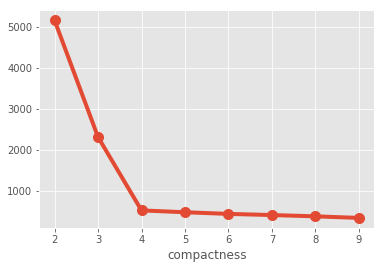

In [46]:
kvals = np.arange(2, 10)
compactness = []
for k in kvals:
    c, _, _ = cv2.kmeans(x.astype(np.float32),
                                         k,  # K与紧凑度的关系
                                         None,
                                         criteria,
                                         10,
                                         flags)
    compactness.append(c)
    
plt.plot(kvals, compactness, 'o-', linewidth=4, markersize=10)
plt.xlabel('kvals - numbers of clusters')
plt.xlabel('compactness')

## 3. 聚类边界是线性的
- K均值算法基于一个简单的假设： 一个点将更加靠近自己的聚类中心，而不是其他的聚类中心
- 因此K均值总是假定聚类类间是线性的边界

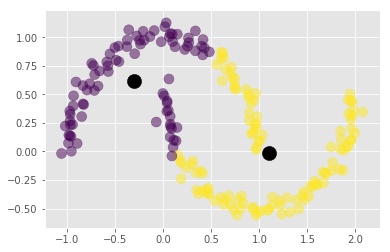

In [12]:
from sklearn import datasets
x, y = datasets.make_moons(200,noise=0.05, random_state=12)  #make_moons

import cv2
# 指定参数：迭代10次，误差小于1.0
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
flags = cv2.KMEANS_RANDOM_CENTERS

import numpy as np
compactness, labels, centers = cv2.kmeans(x.astype(np.float32),
                                         2,
                                         None,
                                         criteria,
                                         10,
                                         flags)

plt.scatter(x[:,0], x[:,1], c=labels[:,0], s=100, alpha=0.5)
plt.scatter(centers[:,0], centers[:,1], c='black', s=200)

In [14]:
labels.shape

(200, 1)

### 解决方法： 一种核化的K均值——谱聚类
- opencv 没有提供
- **scikit-learn: SpectralClustering**

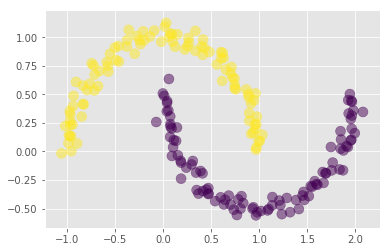

In [15]:
from sklearn.cluster import SpectralClustering
model = SpectralClustering(n_clusters=2,
                          affinity='nearest_neighbors',
                          assign_labels='kmeans')
labels = model.fit_predict(x)

plt.scatter(x[:,0], x[:,1], c=labels, s=100, alpha=0.5)

In [16]:
labels.shape

(200,)

## 4. K均值在处理大数据集时比较慢
- K均值受此影响特别大： K均值每次迭代必须访问数据集中的每个点，然后与所有的聚类中心进行比较。
### 解决方法
- 基于批处理的K均值的变种算法
    - opencv没有提供
    - **scikit-learn: sklearn.cluster.Mini-BatchKMeans**